Total Number of Classes : 36
Class Names : 
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Training Images : 20628
Testing  Images : 1008


Loading: 10800it [00:36, 297.44it/s]
Loading: 1008it [00:03, 335.40it/s]


Training Data Size   : 10816
Validation Data Size : 256
Testing Data Size    : 832


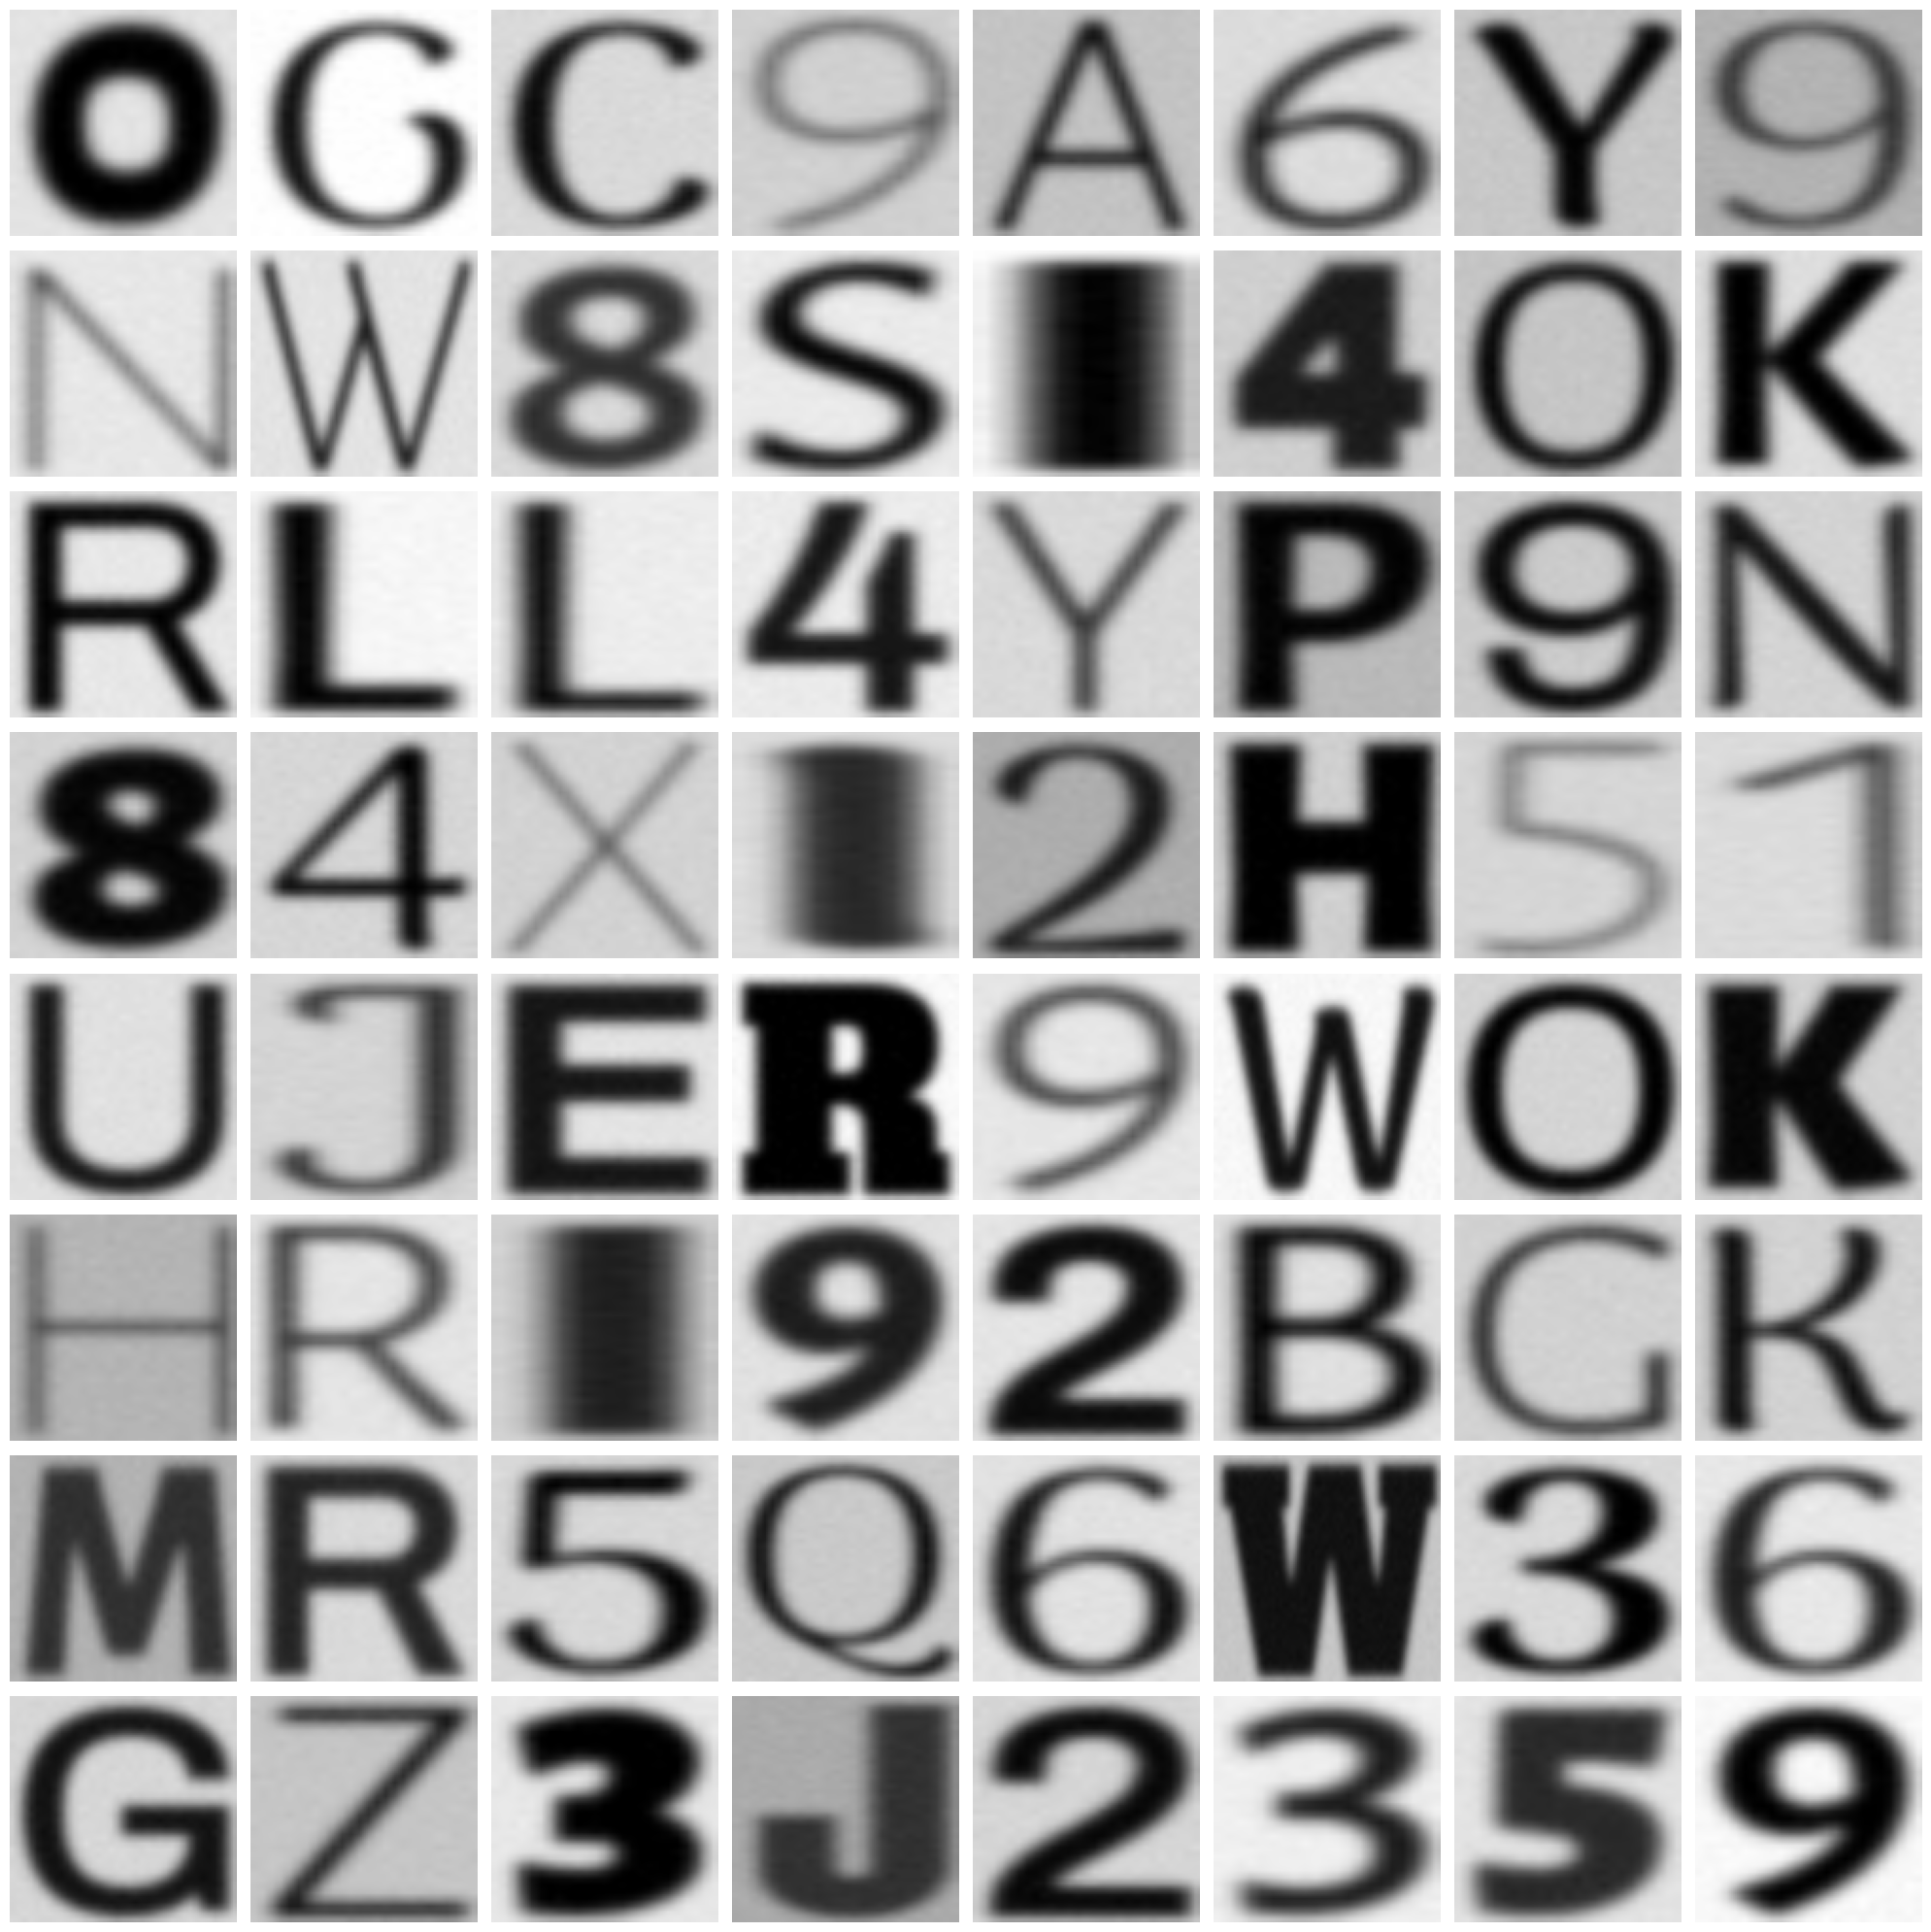

In [2]:
import os
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm 
tfd = tf.data

model = keras.models.load_model('./StandardOCR-ResNet50V2.h5')

# The batch size
BATCH_SIZE = 64

# Image dims 
IMAGE_SIZE = (120,120)                                    # Even this will work

# Buffer size
BUFFER = 1000
# Autotuning
AUTOTUNE = tfd.AUTOTUNE


train_path = "./data/training_data/"
test_path  = "./data/testing_data/"
class_names = sorted(os.listdir(train_path))

# Total number of classes
n_classes = len(class_names)

# Show data 
print(f"Total Number of Classes : {n_classes}")
print(f"Class Names : \n{class_names}")
print(f"Training Images : {sum([len(os.listdir(train_path + name)) for name in class_names])}")
print(f"Testing  Images : {sum([len(os.listdir(test_path + name)) for name in class_names])}")


def load_image(image_path:str):

    
    # Load image file
    image_loaded = tf.io.read_file(image_path)

    try:
        # Decode the png image
        image_decoded = tf.image.decode_png(contents=image_loaded, channels=3)
        
        # Convert the dtype
        image_cnvt = tf.image.convert_image_dtype(image=image_decoded, dtype=tf.float32)

        # Resize the image
        image_resize = tf.image.resize(images=image_cnvt, size=IMAGE_SIZE)

        # Normalize image
        image_norm = tf.clip_by_value(image_resize, clip_value_min=0.0, clip_value_max=1.0)

        # Just for security
        image = tf.cast(x=image_norm, dtype=tf.float32)

        # return
        return image
    except:
        pass

def load_data(root_path, class_names, trim=None, shuffle=False, split=None):

    

    # Collect all file paths
    if trim is not None:
        details = [(path, name) for name in class_names for path in glob(pathname=f"{root_path}/{name}/*.png")[:trim]]
        
    else:
        details = [(path, name) for name in class_names for path in glob(pathname=f"{root_path}/{name}/*.png")]


    # Create space for images and labels
    images = np.empty(shape=(len(details), *IMAGE_SIZE, 3), dtype='float32')
    labels = np.empty(shape=(len(details), 1), dtype='int64')


    # Iterate over all file paths
    for index, (path, name) in tqdm(enumerate(details), desc="Loading"):

        # Load the image
        image = load_image(image_path=path)

        # get the label
        label = class_names.index(name)

        # Store this image and label
        images[index] = image
        labels[index] = label
    
    # Convert the data into tensorflow data
    data_set = tfd.Dataset.from_tensor_slices((
        images, labels
    ))

    # Shuffle if needed
    if shuffle:
        data_set = data_set.shuffle(BUFFER)
    
    # Split the data if needed
    if split is not None:
        
        # get the data sizes
        test_size = int(split * len(images))
        train_size = int(len(images) - test_size)
        
        # Split the data
        train_set = data_set.take(train_size)
        test_set  = data_set.skip(train_size).take(test_size)
        
        # Batchify the data
        train_set = train_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        test_set = test_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        
        # Return data
        return train_set, test_set
    
    else:
        # The whole data
        data_set = data_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        
        # Return complete data
        return data_set
    
train_ds = load_data(root_path=train_path, class_names=class_names, trim=300, shuffle=True)

# Load Validation data
test_ds, valid_ds = load_data(root_path=test_path, class_names=class_names, shuffle=True, split=0.2)

print(f"Training Data Size   : {tf.data.experimental.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.experimental.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.experimental.cardinality(test_ds).numpy() * BATCH_SIZE}")


def show_images(data, GRID=[8,8], FIGSIZE=(20,20), model=None):
    
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_images = GRID[0] * GRID[-1]
    
    # Get the data for data visualization
    images, labels = next(iter(data))
    
    # Iterate over data 
    for n_image, (image, label) in enumerate(zip(images, labels)):
        
        # Plot the image into the subplot.
        plt.subplot(GRID[0], GRID[1], n_image+1)
        plt.imshow(tf.squeeze(image))
        plt.axis('off')
        
        # Adding the title
        if model is not None:
            image = tf.expand_dims(image, axis=0)
            pred = model.predict(image)[0]
            max_index = tf.argmax(pred)
            score = pred[max_index]
            pred_label = class_names[max_index]
            title = "Pred : {}\nScore : {:.4}".format(pred_label, score)
            plt.title(title)
        
        # Break the loop 
        if n_image+1>=n_images:
            break
    
    # Show the final plot
    plt.tight_layout()
    plt.show()

show_images(data = valid_ds)


1/1 [==============================] - 0s 67ms/step


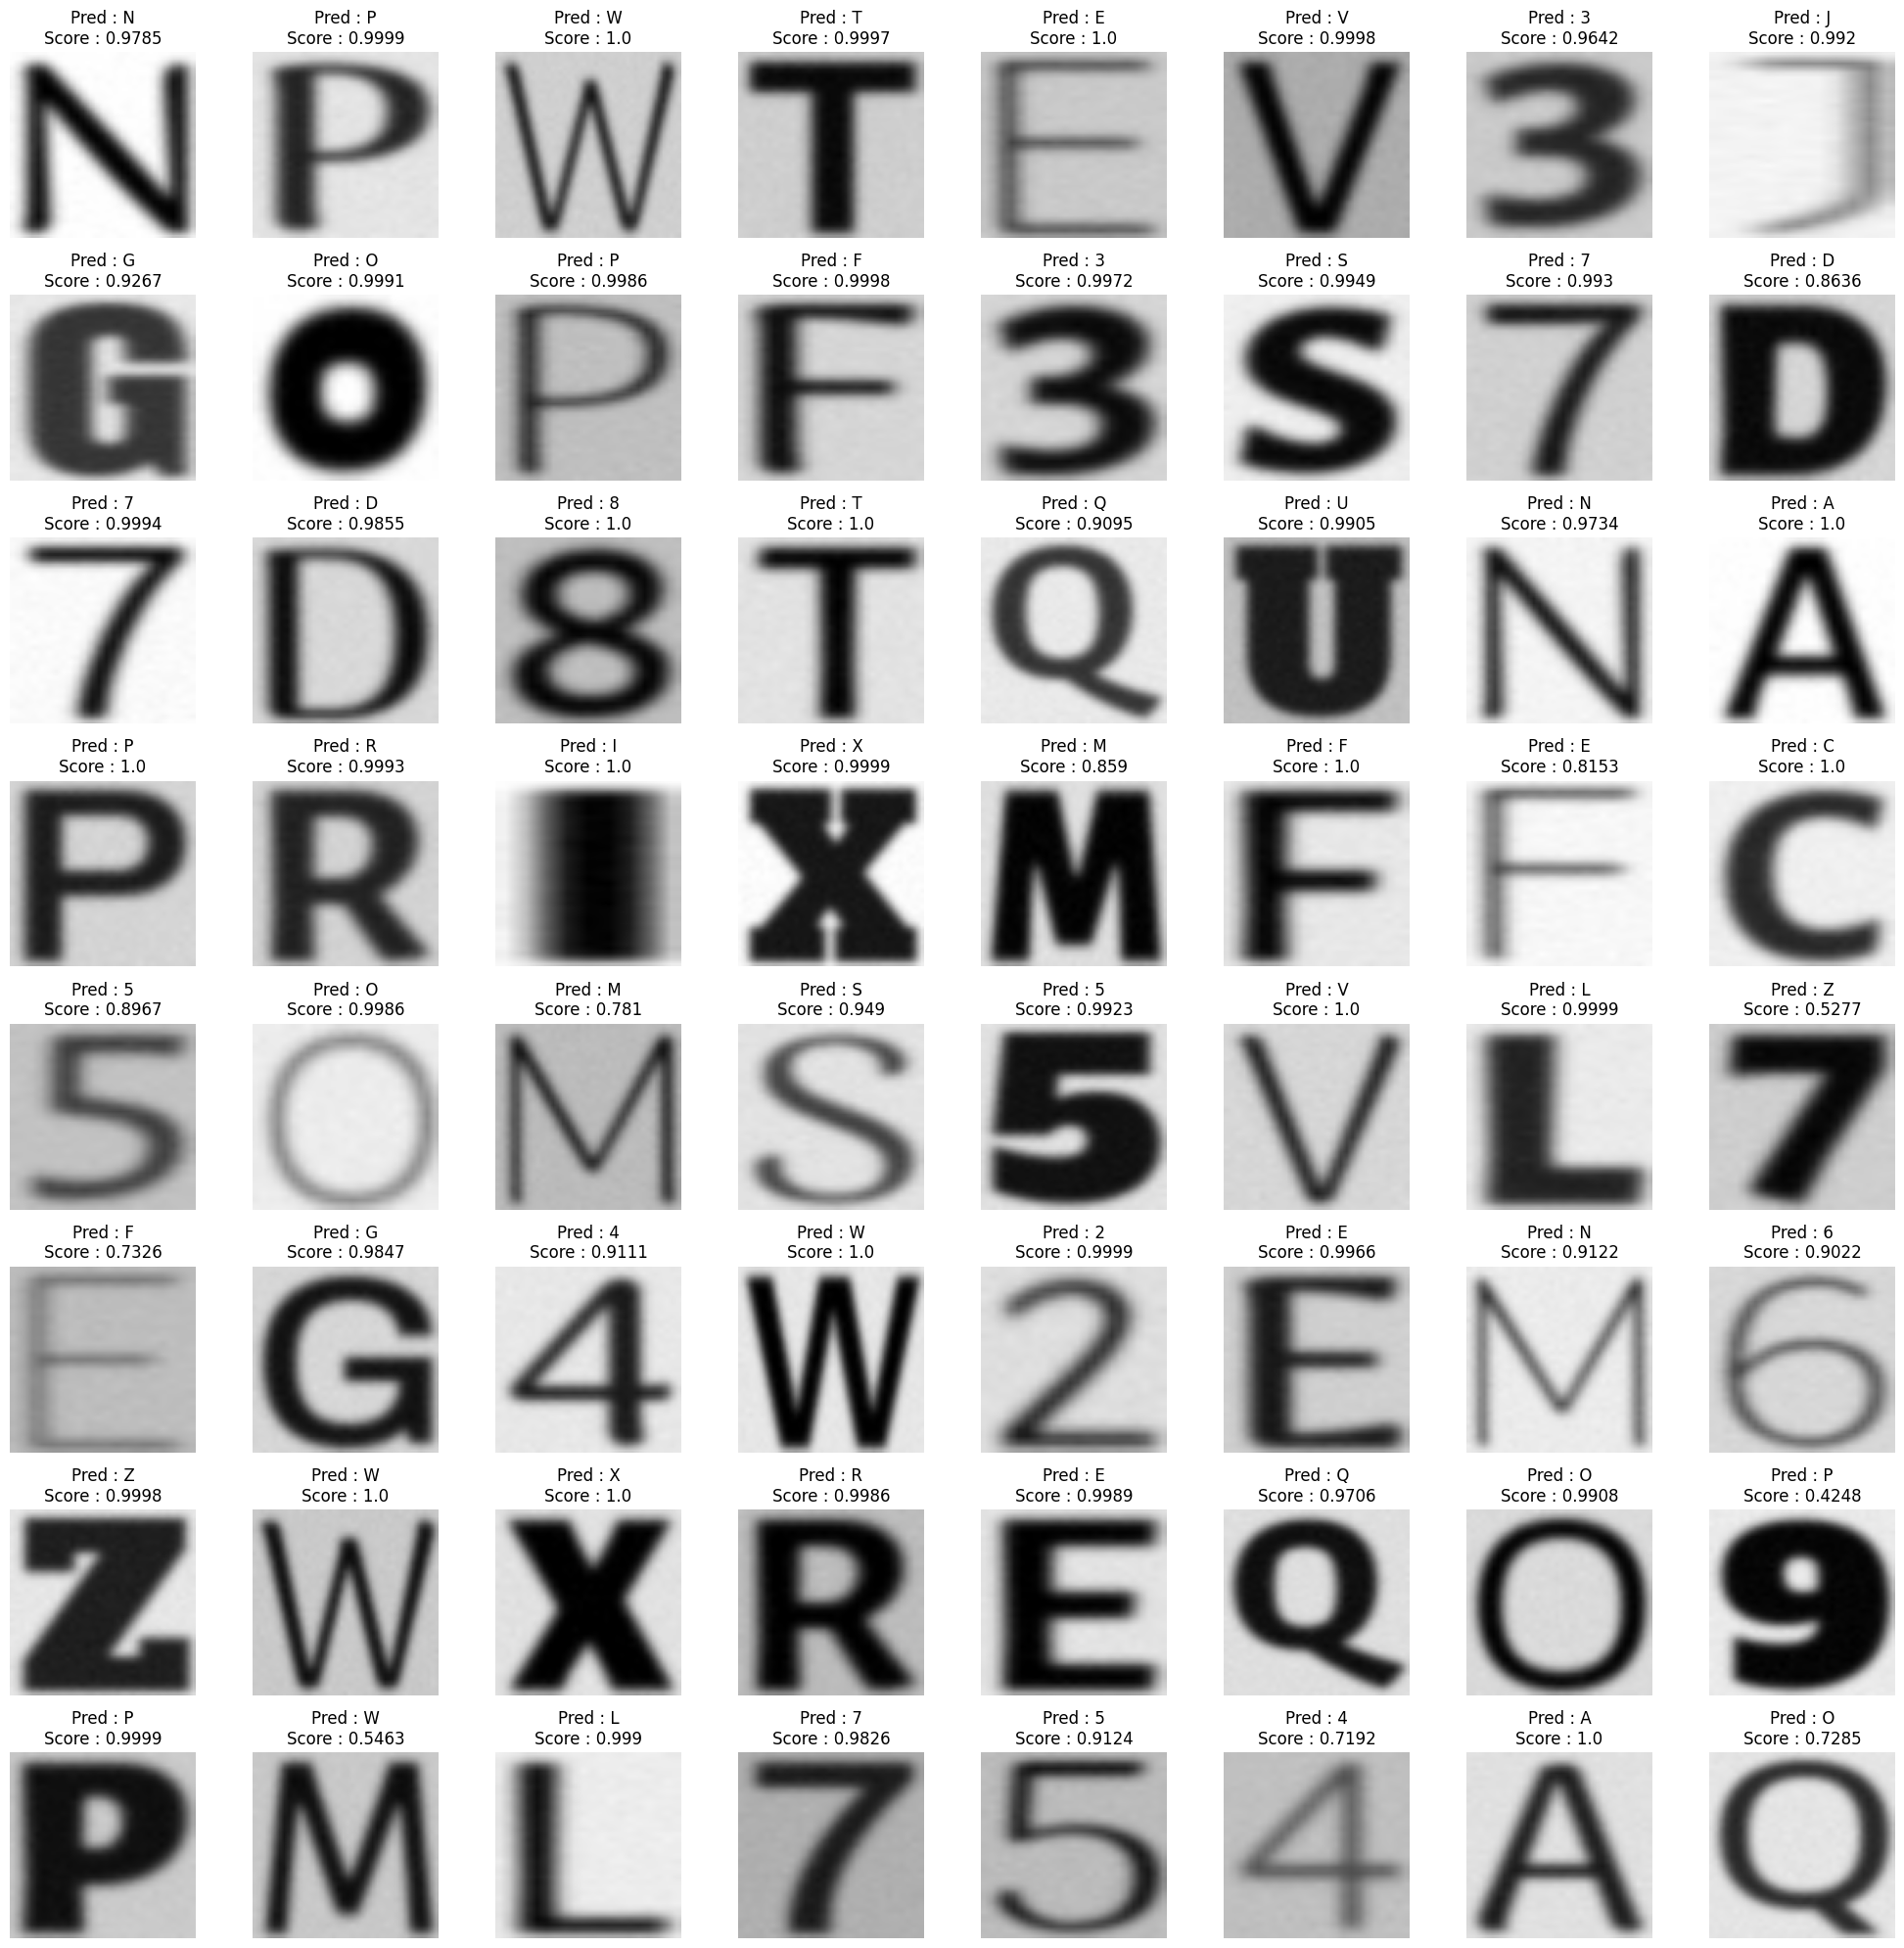

In [3]:

show_images(data=test_ds, model=model)